In [31]:
import pandas as pd
import os
import librosa
from librosa import display
import numpy as np
from tqdm import tqdm
import seaborn as sns
from keras.optimizers import adam
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, SeparableConv1D, Dropout, Dense, Flatten, GlobalAveragePooling1D

In [2]:
file_data = pd.read_csv('file_data.csv')
file_data

,fname,start,end,crack_wheez,fname_cycle
0,101_1b1_Al_sc_Meditron,0.036,0.579,0,101_1b1_Al_sc_Meditron_0.wav
1,101_1b1_Al_sc_Meditron,0.579,2.450,0,101_1b1_Al_sc_Meditron_1.wav
2,101_1b1_Al_sc_Meditron,2.450,3.893,0,101_1b1_Al_sc_Meditron_2.wav
3,101_1b1_Al_sc_Meditron,3.893,5.793,0,101_1b1_Al_sc_Meditron_3.wav
4,101_1b1_Al_sc_Meditron,5.793,7.521,0,101_1b1_Al_sc_Meditron_4.wav
...,...,...,...,...,...
6893,226_1b1_Pl_sc_LittC2SE,11.721,13.693,1,226_1b1_Pl_sc_LittC2SE_6.wav
6894,226_1b1_Pl_sc_LittC2SE,13.693,15.536,0,226_1b1_Pl_sc_LittC2SE_7.wav
6895,226_1b1_Pl_sc_LittC2SE,15.536,17.493,0,226_1b1_Pl_sc_LittC2SE_8.wav
6896,226_1b1_Pl_sc_LittC2SE,17.493,19.436,1,226_1b1_Pl_sc_LittC2SE_9.wav


In [3]:
train_df, test_df = train_test_split(file_data, test_size=0.2, random_state=42, stratify = file_data['crack_wheez'])
train_df

,fname,start,end,crack_wheez,fname_cycle
1902,138_1p2_Pr_mc_AKGC417L,11.461,15.568,1,138_1p2_Pr_mc_AKGC417L_3.wav
5987,205_4b2_Al_mc_AKGC417L,4.994,8.327,1,205_4b2_Al_mc_AKGC417L_1.wav
4453,177_1b2_Pl_mc_AKGC417L,8.406,12.045,1,177_1b2_Pl_mc_AKGC417L_1.wav
3892,170_1b3_Tc_mc_AKGC417L,1.427,4.466,0,170_1b3_Tc_mc_AKGC417L_0.wav
6704,221_2b2_Lr_mc_LittC2SE,5.521,10.036,3,221_2b2_Lr_mc_LittC2SE_2.wav
...,...,...,...,...,...
6313,211_2p3_Tc_mc_AKGC417L,10.193,11.468,0,211_2p3_Tc_mc_AKGC417L_8.wav
6518,217_1b1_Tc_sc_Meditron,11.107,13.293,0,217_1b1_Tc_sc_Meditron_6.wav
6717,221_2b3_Al_mc_LittC2SE,16.764,19.979,2,221_2b3_Al_mc_LittC2SE_4.wav
1598,133_2p3_Ar_mc_AKGC417L,9.946,12.542,0,133_2p3_Ar_mc_AKGC417L_4.wav


In [4]:
#Reset index
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

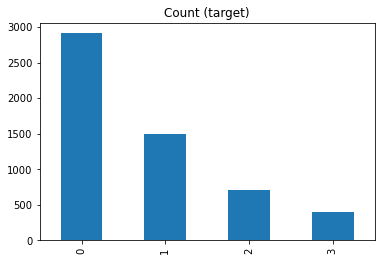

In [5]:
train_df.crack_wheez.value_counts().plot(kind='bar', title='Count (target)')

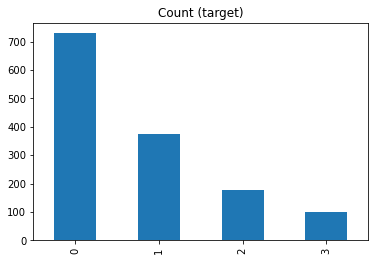

In [6]:
test_df.crack_wheez.value_counts().plot(kind='bar', title='Count (target)')

In [13]:
def audio_features(filename): 
    sound, sample_rate = librosa.load('Breath_cycles/'+filename, sr=None)
    stft = np.abs(librosa.stft(sound,  n_fft=512, hop_length=256))   
    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate,n_fft=512, win_length=400, n_mfcc=40, hop_length = 256, n_mels = 64, fmin = 100, fmax = 1800),axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
    mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate, n_fft=512, win_length=400, hop_length = 256),axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate, n_bands=3),axis=1)
    concat = np.concatenate((mfccs,chroma,mel,contrast))
    return concat

In [14]:
def build_feat(df):
    X = []
    Y = []    
    for i in tqdm(range(len(df))):
        file = df.iloc[i].fname_cycle
        label = df.iloc[i].crack_wheez 
        X_sample = audio_features(file)
        X.append(X_sample)
        Y.append(label)
    X, Y = np.array(X), np.array(Y)
    return X, Y

In [15]:
X_, y_ = build_feat(train_df)

100%|██████████| 5518/5518 [10:14<00:00,  8.98it/s]


In [16]:
y_.shape

(5518,)

In [17]:
X_.shape

(5518, 184)

In [18]:
X_te, y_te = build_feat(test_df)

100%|██████████| 1380/1380 [02:33<00:00,  8.99it/s]


In [19]:
# Hot one encode the labels
y_train = to_categorical(y_)
y_test = to_categorical(y_te)  

In [20]:
y_test.shape

(1380, 4)

In [21]:
X_train = np.reshape(X_, (X_.shape[0], X_.shape[1], 1))
X_test = np.reshape(X_te, (X_te.shape[0], X_te.shape[1],  1))

In [22]:
X_test.shape

(1380, 184, 1)

In [34]:
#Compute class weight for handling unbalanced classes
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
class_weight = compute_class_weight('balanced', np.unique(y_), y_)

In [36]:
def SeperablaConv():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='tanh', input_shape=(184, 1)))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2)) 
    model.add(SeparableConv1D(256, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2)) 
    model.add(SeparableConv1D(256, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2)) 
    model.add(Dropout(0.5))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(512, activation='relu'))   
    model.add(Dense(4, activation='softmax'))
    return model

In [37]:
SeperablaConv().summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 180, 64)           384       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 176, 128)          41088     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 88, 128)           0         
_________________________________________________________________
separable_conv1d_11 (Separab (None, 84, 256)           33664     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 42, 256)           0         
_________________________________________________________________
separable_conv1d_12 (Separab (None, 38, 256)           67072     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 19, 256)          

In [38]:
base_model = SeperablaConv()

In [39]:
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = base_model.fit(X_train, y_train, class_weight= class_weight, validation_data=(X_test, y_test), epochs=70, batch_size=128, verbose=1)

Train on 5518 samples, validate on 1380 samples
Epoch 1/70
5518/5518 [==============================] - 11s 2ms/step - loss: 1.2049 - accuracy: 0.5236 - val_loss: 1.1509 - val_accuracy: 0.5283
Epoch 2/70
5518/5518 [==============================] - 9s 2ms/step - loss: 1.1485 - accuracy: 0.5279 - val_loss: 1.1465 - val_accuracy: 0.5283
Epoch 3/70
5518/5518 [==============================] - 9s 2ms/step - loss: 1.1466 - accuracy: 0.5279 - val_loss: 1.1403 - val_accuracy: 0.5283
Epoch 4/70
5518/5518 [==============================] - 9s 2ms/step - loss: 1.1346 - accuracy: 0.5277 - val_loss: 1.1281 - val_accuracy: 0.5290
Epoch 5/70
5518/5518 [==============================] - 9s 2ms/step - loss: 1.1167 - accuracy: 0.5283 - val_loss: 1.0864 - val_accuracy: 0.5326
Epoch 6/70
5518/5518 [==============================] - 9s 2ms/step - loss: 1.0683 - accuracy: 0.5440 - val_loss: 1.0808 - val_accuracy: 0.5196
Epoch 7/70
5518/5518 [==============================] - 9s 2ms/step - loss: 1.0255 - ac

                precision    recall  f1-score   support

          None       0.73      0.77      0.75       729
       Crackle       0.59      0.57      0.58       373
        Wheeze       0.47      0.47      0.47       177
Crackle_wheeze       0.36      0.25      0.29       101

      accuracy                           0.64      1380
     macro avg       0.54      0.51      0.52      1380
  weighted avg       0.63      0.64      0.63      1380



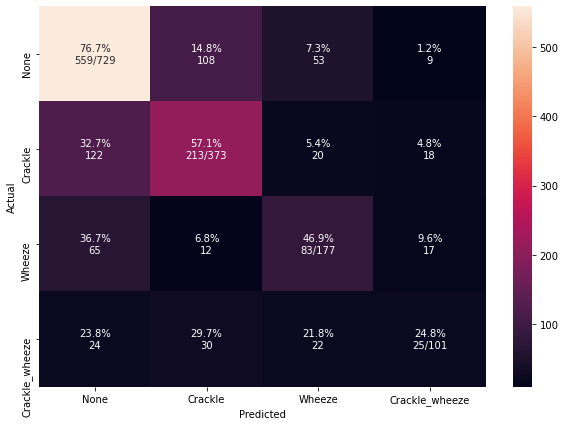

In [40]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
matrix_index = ["None", "Crackle", "Wheeze", "Crackle_wheeze"]

preds = base_model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')